In [1]:
import tensorflow as tf
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications import MobileNetV3Large,VGG16
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
## Resize all the images
IMAGE_SIZE = [224,224]

In [5]:
train_path = "/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/train"
valid_path = "/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/valid"
test_path =  "/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/test"

In [6]:
## Add Preprocessing to the front
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
## Don't train existing weights
for layer in vgg16.layers:
    layer.trainable=False

In [8]:
## Getting Number of Classes
folders = glob("/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/train/*")
print(folders,len(folders))

['/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/train/Positive', '/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/train/Negative'] 2


In [9]:
## Add layer
x = Flatten()(vgg16.output)
pred = Dense(2,activation='softmax')(x)

In [10]:
## Create a model object
model = Model(inputs=vgg16.input , outputs=pred)

In [11]:
## Let's compile our model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [12]:
## View the structure of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  )


valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_set = train_datagen.flow_from_directory(train_path,
                                             batch_size=32,
                                             target_size = (224,224),
                                             class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                           batch_size=32,
                                           target_size=(224,224),
                                           class_mode='categorical')

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [15]:
## Fit the Model
result = model.fit(train_set,
                   validation_data=valid_set,
                   epochs=100,
                   steps_per_epoch=len(train_set),
                   validation_steps=len(valid_set),
                   callbacks=[
                        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
                   ]
                    )

Epoch 1/100
19/19 [==============================] - 266s 14s/step - loss: 0.7940 - accuracy: 0.6750 - val_loss: 0.5451 - val_accuracy: 0.7150
Epoch 2/100
19/19 [==============================] - 10s 499ms/step - loss: 0.2756 - accuracy: 0.8883 - val_loss: 0.2795 - val_accuracy: 0.8600
Epoch 3/100
19/19 [==============================] - 9s 494ms/step - loss: 0.2793 - accuracy: 0.8817 - val_loss: 0.3819 - val_accuracy: 0.8300
Epoch 4/100
19/19 [==============================] - 9s 493ms/step - loss: 0.1897 - accuracy: 0.9283 - val_loss: 0.3453 - val_accuracy: 0.8500
Epoch 5/100
19/19 [==============================] - 10s 500ms/step - loss: 0.1615 - accuracy: 0.9400 - val_loss: 0.1887 - val_accuracy: 0.9150
Epoch 6/100
19/19 [==============================] - 10s 505ms/step - loss: 0.1369 - accuracy: 0.9617 - val_loss: 0.1701 - val_accuracy: 0.9200
Epoch 7/100
19/19 [==============================] - 10s 498ms/step - loss: 0.1332 - accuracy: 0.9517 - val_loss: 0.2816 - val_accuracy: 0.

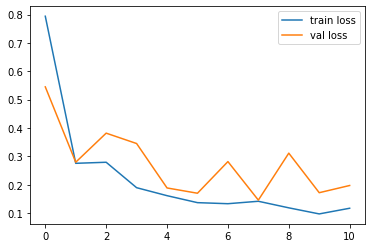

In [16]:
# loss
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()

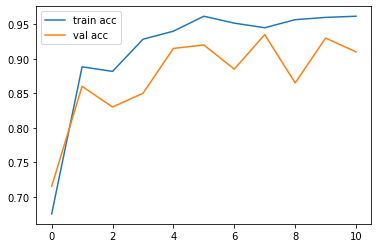

In [17]:
# accuracies
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
 

In [18]:
model.save('Bridge_model.h5')

In [19]:
results = model.evaluate(test_set, verbose=0)
loss = results[0]
acc = results[1]

print("    Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(acc * 100))

    Test Loss: 0.05666
Test Accuracy: 99.00%


In [20]:
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_set.classes, y_pred)
print(cm)

7/7 [==============================] - 1s 161ms/step
[[54 46]
 [48 52]]


In [21]:
clr = classification_report(test_set.classes, y_pred, target_names=["NEGATIVE", "POSITIVE"])
print(clr)

              precision    recall  f1-score   support

    NEGATIVE       0.53      0.54      0.53       100
    POSITIVE       0.53      0.52      0.53       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200

